# Behaviorial Cloning Project


## Behavioral Cloning Project

The goals / steps of this project are the following:
* Use the simulator to collect data of good driving behavior
* Build, a convolution neural network in Keras that predicts steering angles from images
* Train and validate the model with a training and validation set
* Test that the model successfully drives around track one without leaving the road
* Summarize the results with a written report


## Rubric Points
Here I will consider the [rubric points](https://review.udacity.com/#!/rubrics/432/view) individually and describe how I addressed each point in my implementation.  

### Files Submitted & Code Quality

#### 1. Submission includes all required files and can be used to run the simulator in autonomous mode


My project includes the following files:
* model.py containing the script to create and train the model
* drive.py for driving the car in autonomous mode
* model.h5 containing a trained convolution neural network 
* writeup_report.pdf summarizing the results
* Video.mp4 showing the my model results with track1
* Video_track2.mp4 showing the my model results with track2


### Quality of Code

#### 1. My code is fullly functional


My model.py contains all the code required to reproduce the results. I will also show the code blocks in below cells 

#### 2. My code is usable and readable

* The model.py can be executed simply by `python model.py`. 
* Many small functions have been defined to improve the readability of the `model.py`
* Data generator is used in my `model.py` to feed data during the training process

### Model Architecture and Training Strategy

#### 1.  Has an appropriate model architecture been employed for the task?

My model consists of below layers:
* A cropping layer to crop off the unuseful information
* A lamda normalization lay
* Two convolution layers (kernal sizes: 5x5, 5x5)
* Two dense layers 

The model includes ELU layers to introduce nonlinearity. 

#### 2. Has an attempt been made to reduce overfitting of the model?
* The model contains two dropout layers in order to reduce overfitting. 
* `train_test_split()` was used to split 30% data for validation. 
* No need to generate test data here as we are going to test the model in the simulator


#### 3.Have the model parameters been tuned appropriately?


* epoches was tuned. During tuning process I found that epoches can not be too large. If it is larger than 10, I will have over fitting issue and have worse results. 
* batch_size was tunned but I did not notice any impact on the results. 
* Adam optimizer was used in my model and the default learning rate 0.001 is used. 



#### 4. Is the training data chosen appropriately?

Training data was chosen to keep the vehicle driving on the road. 
* Both left, right and center images are used for training.
* Recovering from left/right sides of road is used to teach model how to recover from error
* Training data is also collected from track 2 to teach mode to drive on track 2

For details about how I created the training data, see the next section. 

### Model Architecture and Training Strategy
#### 1. Solution Design Approach

Although this is not a image classfication problem, we are still trying to teach the neural network to understand the image and take some action. Therefore, I believe CNN + Dense layers is the right direction to go.  

My first step was to use a convolution neural network model similar to the [NVIDIA CNN](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) , I thought this model might be appropriate because it was designed to solve the same problem like here. However, I found that the NVIDIA CNN was too complicate to train on my laptop. Even training one epoch take more than one day on my Thinkpad w541 laptop. So a simplified network is used by me.

In order to gauge how well the model was working, I split my image and steering angle data into a training and validation set. I found that my first model had a low mean squared error on the training set but a high mean squared error on the validation set. This implied that the model was overfitting.


### 2. Final Model Architecture

My final model architecture is like this:
* Cropping layer to remove some pixel rows in top and bottom part of images
* One lambda layer to normalize image data to (-0.5, 0.5)
* Convolutional layer: depth 3, kernel_size = (5, 5), strides=(1, 1), activation='elu'
* Max pooling layer: pool_size=(3, 3), strides=(2, 2)
* Convolutional layer: depth 24, kernel_size = (5, 5), strides=(1, 1), activation='elu'
* Max pooling layer: pool_size=(3, 3), strides=(2, 2)
* Drop out layer 
* Fully connected layer (128) 
* Drop out layer 
* Fully connected layer (1)


Here is a visualization of the architecture by using 'plot_model' from keras.utils:
![Keras Network Model](model.png)


#### 3.creation of the training dataset and training process 

Track1 training data used by me is from Udacity. However, I found that the data from udacity is biased towards steering angle zero. The visualization of steering angle histogram is as blow. When I first used this training data to train my mode and I found my mode is also biased towards 0 steering angle and will lean towards driving in a stright line.  
To combact this issue, I randomly dropped 0 steering angle training data during my training process. 

With data augmentation, my model can drive on track 1 for hours without any issue. However, when I try the trained model on track 2, my model always drive off the track. Therefore, I also collected training data from track 2. And with this additional training data, my mode can drive on both tracks without issues. 



In [6]:
import csv
import cv2
import numpy as np
import os.path
import matplotlib.pyplot as plt

def parse_csv_file_to_lines(csvfile):
    
    assert(os.path.exists(csvfile))
    firstline = True;
    csv_lines = []
    with open(csvfile, 'r') as csvdata:
        reader = csv.reader(csvdata)
        for line in reader:
            if firstline:
                firstline = False
                continue                  
            csv_lines.append(line)
    return csv_lines

def parse_csv_lines_to_images_steers(csv_lines, img_path):
    center_images = []
    left_images = []
    right_images = []
    measurements = []
    firstline = True;
    for line in csv_lines:
        if firstline:
            firstline = False
            continue        
        # Centre camera image 
        source_path = line[0]
        filename = source_path.split('/')[-1]
        current_path = img_path + filename
        image = cv2.imread(current_path)
        center_images.append(image)
        # Left camera image 
        source_path = line[1]
        filename = source_path.split('/')[-1]
        current_path = img_path + filename
        image = cv2.imread(current_path)
        left_images.append(image)
        # Right camera image
        source_path = line[2]
        filename = source_path.split('/')[-1]
        current_path = img_path + filename
        image = cv2.imread(current_path)
        right_images.append(image)
        
        steer = float(line[3])
        measurements.append(steer)
    return center_images, left_images, right_images, measurements



In [7]:
CSV_PATH_TRACK1        = 'data/track1/driving_log.csv' 
IMG_PATH_TRACK1        = 'data/track1/IMG/'
csv_lines_track1       = parse_csv_file_to_lines(CSV_PATH_TRACK1)
csv_lines              = csv_lines_track1
centers, lefts, rights, steerings = parse_csv_lines_to_images_steers(csv_lines, IMG_PATH_TRACK1)


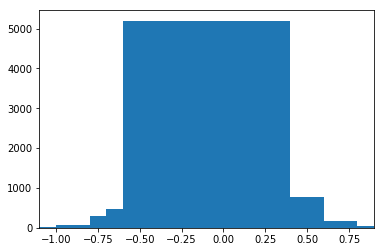

In [15]:
def plot_training_data_steering_histogram(measurements):
    measurements = np.array(measurements, dtype=np.float32)
    bins = np.arange(-1.1, 1.0, 0.1)
    hist,bin_edges = np.histogram(measurements, bins=bins)
    plt.bar(bin_edges[:-1], hist, width = 1)
    plt.xlim(min(bin_edges), max(bin_edges))
    plt.show()
    
plot_training_data_steering_histogram(steerings)


Visualize one set of training data, including center, left and right camera images and its steering angle. 

idx 353 steering angle 0.0


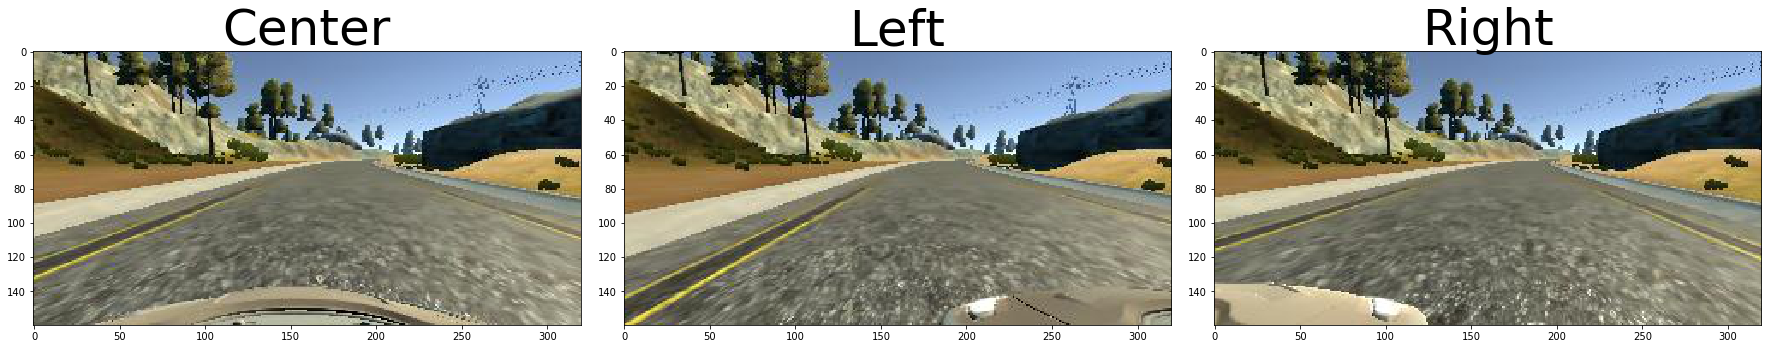

In [28]:
idx = np.random.randint(len(centers));
center_img = centers[idx]
left_img = lefts[idx]
right_img = rights[idx]

print('idx ' + str(idx) + ' steering angle ' + str(steerings[idx]))
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(center_img, cv2.COLOR_BGR2RGB))
ax1.set_title('Center', fontsize=50)
ax2.imshow(cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB))
ax2.set_title('Left', fontsize=50)
ax3.imshow(cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB))
ax3.set_title('Right', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


To boost the performance, I also use below data augmentation techniques to expand tha training data set. 
##### Brightness augmentation


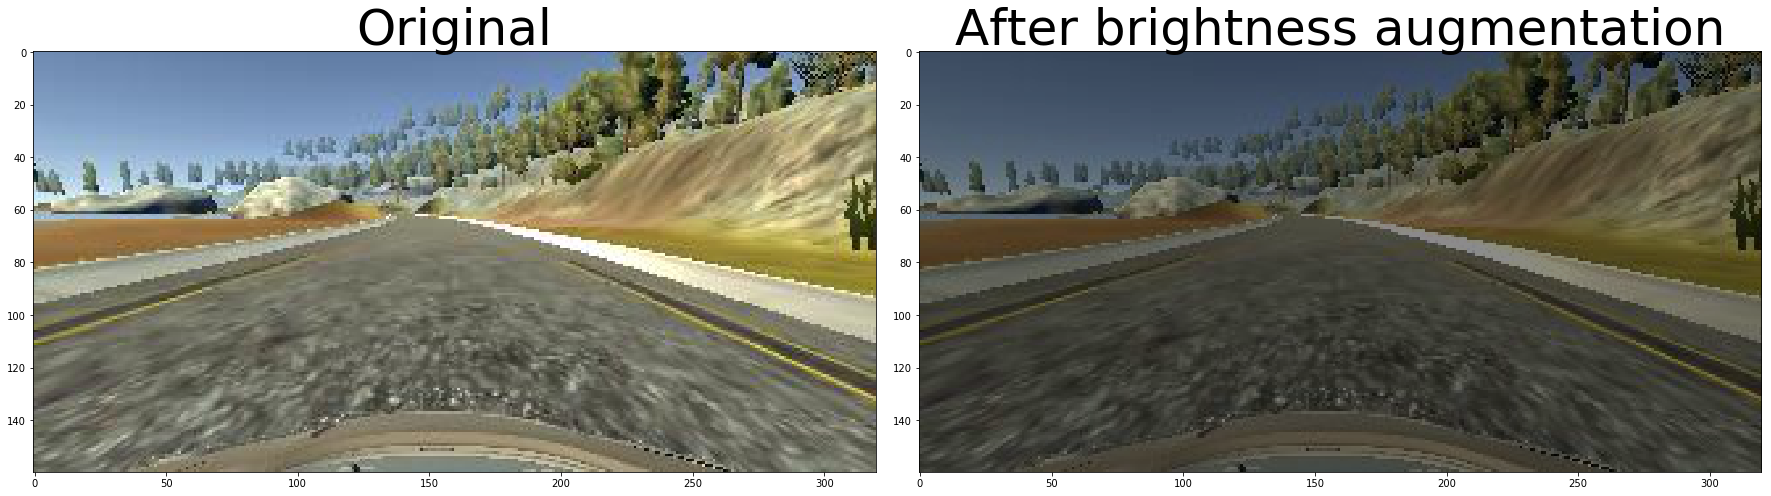

In [30]:
def augment_randomize_brightness(image, v_lo_ratio, v_hi_ratio):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Convert to numpy array
    hsv = np.array(hsv, dtype=np.float64)
    v_adjust_ratio = np.random.uniform(v_lo_ratio, v_hi_ratio)
    hsv[:,:,2] = hsv[:,:,2] * v_adjust_ratio
    hsv[:,:,2][hsv[:,:,2] > 255] = 255
    # Convert back to integer image 
    hsv = np.array(hsv, dtype=np.uint8)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

idx = np.random.randint(len(centers));
center_img  = centers[idx]
center_img2 = augment_randomize_brightness(center_img, 0.3, 1.5)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(cv2.cvtColor(center_img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original', fontsize=50)
ax2.imshow(cv2.cvtColor(center_img2, cv2.COLOR_BGR2RGB))
ax2.set_title('After brightness augmentation', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()




##### Shfit image horizontally and verifcally

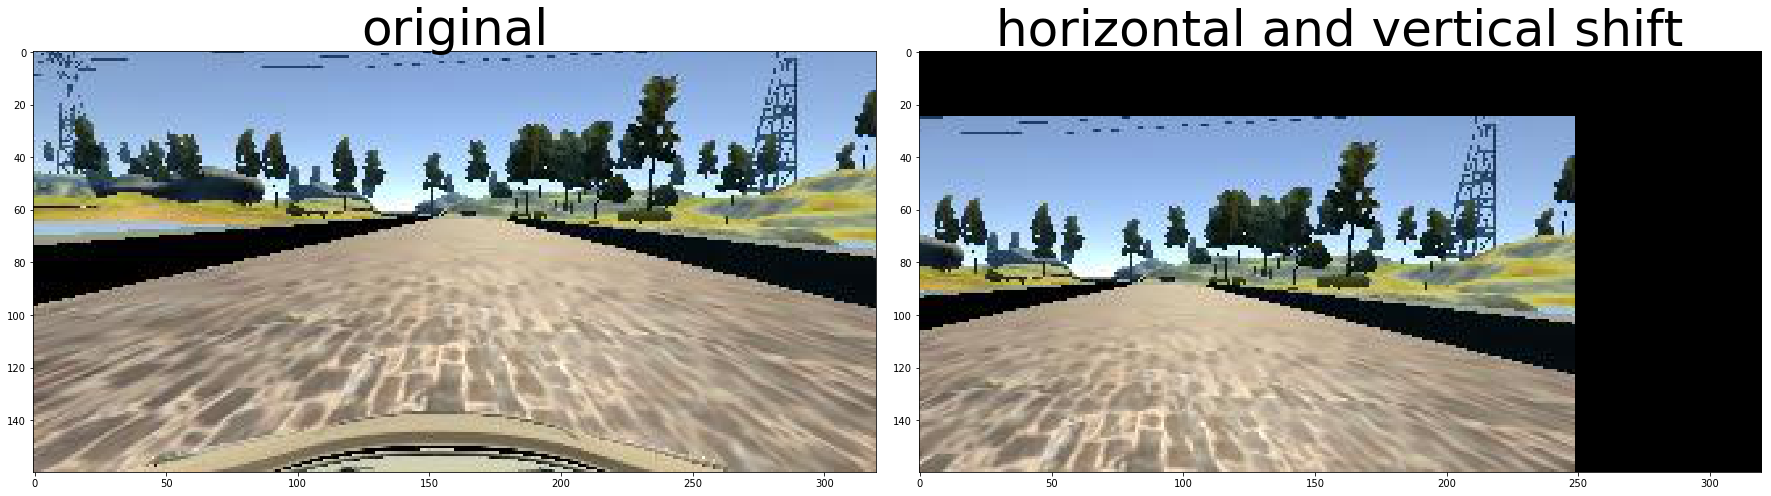

In [35]:
# Randomly shift image horizontally and vertically 
def augment_randomize_horizontal_vertical_shift(image, measurement, shift_range=100):
    height = image.shape[0]
    width = image.shape[1]
    # Do not allow too large shift 
    shift_range = max(shift_range, width/2)
    # Adjust steering angle 0.0035 per horizontal shit
    shift_x = int(shift_range*np.random.uniform()-shift_range/2)
    measurement = measurement + 0.0035 * shift_x
    # Shift less in vertical direction
    shift_range = int(shift_range/3)
    shift_y = int(shift_range*np.random.uniform()-shift_range/2)
    transform_matrix = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    # numpy array store image in the (height, width, channel) order
    # CV2 need (width, height) order
    image = cv2.warpAffine(image,transform_matrix, image.shape[:2][::-1])
    return image, measurement

idx = np.random.randint(len(centers));
center_img  = centers[idx]
center_img2, _ = augment_randomize_horizontal_vertical_shift(center_img, steerings[idx], 120)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(cv2.cvtColor(center_img, cv2.COLOR_BGR2RGB))
ax1.set_title('original', fontsize=50)

ax2.imshow(cv2.cvtColor(center_img2, cv2.COLOR_BGR2RGB))
ax2.set_title('horizontal and vertical shift', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


##### Flip Image

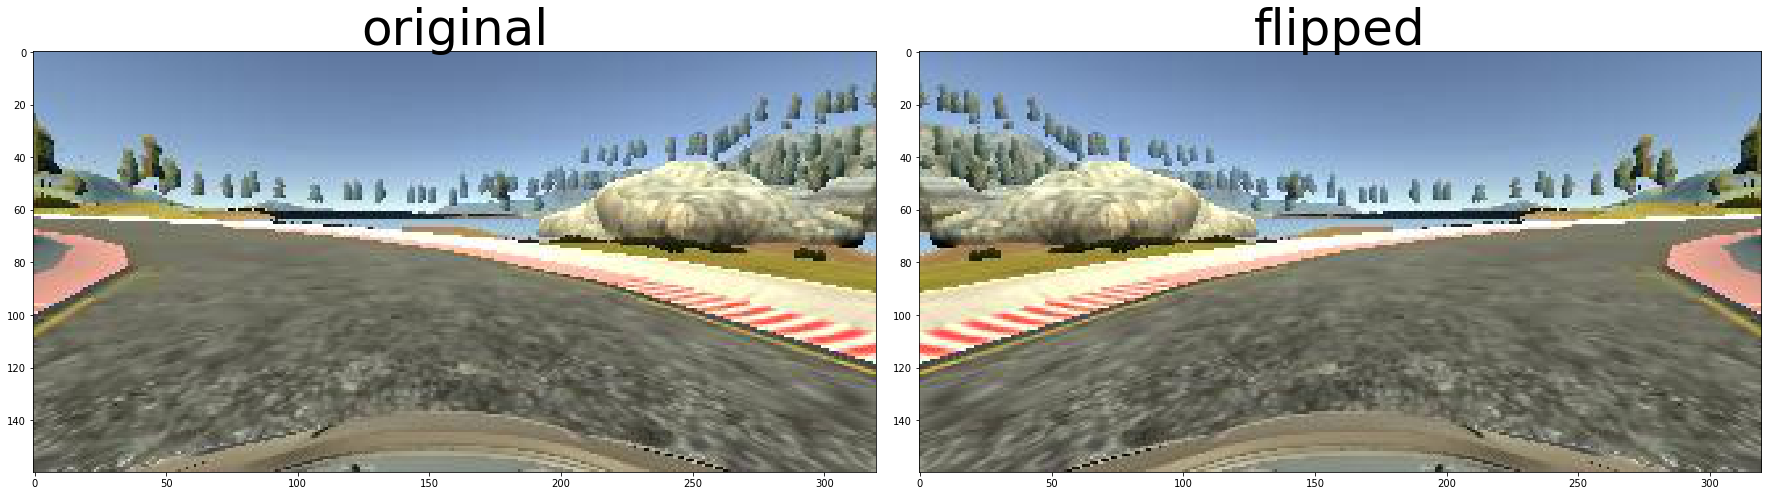

In [36]:
def augment_randomize_flip_image(image, measurement):
    # randomly flip the images
    if np.random.randint(0, 2) == 0:
        image = cv2.flip(image, 1)
        measurement = measurement * (-1.0)
    return image, measurement

idx = np.random.randint(len(centers));
center_img  = centers[idx]
center_img2, _ = augment_randomize_flip_image(center_img, steerings[idx])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(cv2.cvtColor(center_img, cv2.COLOR_BGR2RGB))
ax1.set_title('original', fontsize=50)

ax2.imshow(cv2.cvtColor(center_img2, cv2.COLOR_BGR2RGB))
ax2.set_title('flipped', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


I split the 30% training data for as validation data set. The validation set helped determine if the model was over or under fitting. The epoches size was choose as `10` and I found that a too large epoches size is not necessary helpful for this project. I 


I created a data generator named `get_img_steering_data()`, which will randomly pick one line from the `driving_data.csv` and will 
* randomly slelect which image to use: center, left or right
* randomly adjust brightness
* randomly perform horizontal and veritcal 
* randomly flip image
* randomly ignore training data with small steering angle

The data generator in theory can generate unlimited number of training data. 

In [37]:
def get_img_steering_data(csv_line_data, img_path):
    line = list(csv_line_data)
    assert(len(line) >= 4)
    img_left_center_right = np.random.randint(3)
    shift_angle = 0.0 
    # Get the steering measurement
    measurement = float(line[3])
    if img_left_center_right == 0: # Center img
        shift_angle = 0.0
        source_path = line[0]
        filename = source_path.split('/')[-1]
        cur_img_path = img_path + filename
        # Make sure the image file exist
        assert(os.path.exists(cur_img_path))
    elif img_left_center_right == 1: # Left img 
        # Adjust steer angle by small value
        shift_angle += 0.28
        source_path = line[1]
        filename = source_path.split('/')[-1]
        cur_img_path = img_path + filename
        # Make sure the image file exist
        assert(os.path.exists(cur_img_path))
    else: #img_left_center_right == 2: ## Right img
        # Adjust steer angle by small value
        shift_angle -= 0.28
        source_path = line[2]
        filename = source_path.split('/')[-1]
        cur_img_path = img_path + filename
        # Make sure the image file exist
        assert(os.path.exists(cur_img_path))
    measurement += shift_angle
    image = cv2.imread(cur_img_path)
    # CV will load image as BGR, convert it back to RGB
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    # Randomly adjust brightness 
    image = augment_randomize_brightness(image, 0.4, 1.6)
    # Randomly shift in horizontally and vertical direction
    image, measurement = augment_randomize_horizontal_vertical_shift(image, measurement)
    # Randomly flip the image 
    image, measurement = augment_randomize_flip_image(image, measurement)
    return image, measurement

# Data batch generator 
def generate_training_data_batch(csv_lines, img_path, batch_size = 32, small_steering_th = 0.1):
    assert(os.path.exists(img_path))
    data      = csv_lines
    images    = np.zeros((batch_size, IMG_H, IMG_W, IMG_CH))
    steerings = np.zeros(batch_size)

    while 1:
        for batch_idx in range(batch_size):
            line_data = data[np.random.randint(1, len(data))]
            found_good_data = 0
            while found_good_data == 0:
                img, steering = get_img_steering_data(line_data, img_path)
                if abs(steering) >= small_steering_th:
                    found_good_data = 1
                    break
                else:
                    # Randomly drop small steering angle data p
                    random_keep = np.random.uniform(0.0, min(small_steering_th * 3.0, 1.0))
                    if random_keep > small_steering_th:
                        found_good_data = 1
            images[batch_idx]    = img
            steerings[batch_idx] = steering
        yield images, steerings